In [1]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D,Dropout

import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical
import numpy as np
from PIL import Image, ImageEnhance, ImageOps
import skimage
import cv2

from scipy import ndimage, misc

import os


Using TensorFlow backend.


Два Преобразования картинок, которые помогают сделать лучше модель за счет того, что на входе у нас подаются зашумленные картинки. Виды зашумлений:

1. Добавление полей (как черных, так и белых)
2. Добавление рандомного гауссовского шума на картинку
3. Вращение картинки 

In [2]:
def modify_train_image(image):
    frame_width = np.random.randint(0, 3)
    fill_in_black = np.random.randint(255-30, 254)
    rotation_angle = np.random.randint(-35, 35)
    mode = "gaussian"
    image=skimage.util.random_noise(image, mode=mode)
    
    im_from_array = Image.fromarray((255 * image.reshape(28, 28)).astype(np.uint8))
    img_with_border = ImageOps.expand(im_from_array,
                                  border=frame_width,fill=fill_in_black)
    rotated = img_with_border.rotate(rotation_angle)
    resized = rotated.resize((28 ,28),Image.ANTIALIAS)
    
    return np.array(resized)

In [3]:
def modify_train_image_v2(image):
    frame_width = 10
    rotation_angle = np.random.randint(0, 20)
    mode = "gaussian"
    сonst_cut_value = 15
    left_to_cut = np.random.randint(1, сonst_cut_value)
    right_to_cut = сonst_cut_value-left_to_cut
    top_to_cut = np.random.randint(1, сonst_cut_value)
    bottom_to_cut = сonst_cut_value - top_to_cut
    #
    
    im_from_array = Image.fromarray((image.reshape(28, 28)).astype(np.uint8))
    img_with_border = ImageOps.expand(im_from_array,
                                  border=frame_width,fill=255)
    rotated = img_with_border.rotate(rotation_angle)
    resized = np.array(rotated)
    resized=skimage.util.random_noise(resized, mode=mode)
    resized = (255 * resized).astype(np.uint8)
    resized = resized[left_to_cut: -right_to_cut, top_to_cut:-bottom_to_cut]
    
    resized = Image.fromarray(resized)
    resized = resized.resize((28, 28),Image.ANTIALIAS)
    resized = np.array(resized)
    
    return resized

Тут надо сконвертить в черные цифры на белом фоне

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = 255 - X_train
X_test = 255 - X_test

In [5]:
X_train_modified = np.array(list(map(modify_train_image, X_train)))
X_test_modified = np.array(list(map(modify_train_image, X_test)))



In [6]:
X_train_modified_2 = np.array(list(map(modify_train_image_v2, X_train)))
X_test_modified_2 = np.array(list(map(modify_train_image_v2, X_test)))



`our_sample_digits` – папка, в ней сложены наши семплы картинок, которые у нас получились из вырезок настоящих бланков

In [7]:
digits_to_add = dict()

for filename in os.listdir("our_sample_digits"):
    if ".png" in filename:
        filepath = "our_sample_digits/{}".format(filename)
        im=Image.open(filepath)
        im=im.resize((28 ,28),Image.ANTIALIAS)
        im = np.array(im)

        digit = filename[0]
        current_digits = digits_to_add.get(digit, [])
        current_digits.append(im)
        digits_to_add[digit] = current_digits
        

In [8]:
X_train_self_created = []
y_train_self_created = []


sample_size = 3000
for i in range(10):
    y_s = sample_size * [i]
    x_s = digits_to_add[str(i)]
    x_s = np.array(x_s)
    row_i = np.random.choice(x_s.shape[0],size=sample_size)
    x_s = x_s[row_i]
    x_s = list(x_s)
    #x_s = np.random.choice(, sample_size)
    X_train_self_created += x_s
    y_train_self_created += y_s


In [9]:
X_test_self_created = []
y_test_self_created = []


sample_size = 1000
for i in range(10):
    y_s = sample_size * [i]
    x_s = digits_to_add[str(i)]
    x_s = np.array(x_s)
    row_i = np.random.choice(x_s.shape[0],size=sample_size)
    x_s = x_s[row_i]
    x_s = list(x_s)
    #x_s = np.random.choice(, sample_size)
    X_test_self_created += x_s
    y_test_self_created += y_s


Очищение отсканированных "настоящих" картинок: увеличение контрастности, уменьшение шума 

In [10]:
def pretty_scanned_digit(image_array):
    delta = 0
    separator = 120
    factor = 10
    
    im = Image.fromarray(image_array.astype(np.uint8))
    initial_image = Image.fromarray(image_array.astype(np.uint8))
    enhancer = ImageEnhance.Contrast(im)

    im = np.array(enhancer.enhance(factor))
    
    morph = im.copy()
    if len(im.shape) == 3:
        gray_image = np.min(im, axis=2)
    else:
        gray_image = im
    result = ndimage.gaussian_filter(gray_image, 0)

    gray_image_for_prediction=result
    im_from_array = Image.fromarray(gray_image_for_prediction)
    im_from_array = im_from_array.resize((28 +2 * delta,28 + 2 * delta),Image.ANTIALIAS)
    gray_image_for_prediction = np.array(im_from_array).reshape(28, 28)
    gray_image_for_prediction[gray_image_for_prediction > separator] = 255
    return gray_image_for_prediction

Собтвенный семпл циферок 2мя способами добавляю в датасет. 
1. Очистка + наложение шумов
2. Просто наложение шумов

In [11]:
X_train_self_created_pretty = list(map(pretty_scanned_digit, X_train_self_created))
X_train_self_created_pretty = list(map(modify_train_image_v2, X_train_self_created_pretty))

X_train_self_created_not_pretty = list(map(modify_train_image_v2, X_train_self_created))

X_test_self_created_pretty = list(map(pretty_scanned_digit, X_test_self_created))
X_test_self_created_pretty = list(map(modify_train_image_v2, X_test_self_created_pretty))

X_test_self_created_not_pretty = list(map(modify_train_image_v2, X_test_self_created))



In [14]:
240000/6

40000.0

Датасет для обучения состоит из нескольких частей
1. Сам Mnist
2. Mnist преобразованный `modify_train_image`
3. Mnist преобразованный `modify_train_image_v2`
4. Собственный семпл, отсемплированный N раз, очищенный и преобразованный  `modify_train_image_v2`, 
4. Собственный семпл, отсемплированный N раз и  преобразованный  `modify_train_image_v2`, 

In [12]:
X_train = np.concatenate([X_train, X_train_modified, X_train_modified_2, 
                          X_train_self_created_pretty, X_train_self_created_not_pretty])
X_test = np.concatenate([X_test, X_test_modified, X_test_modified_2, 
                        X_test_self_created_pretty, X_test_self_created_not_pretty])

y_train = np.concatenate([y_train, y_train, y_train,
                         y_train_self_created, y_train_self_created])
y_test = np.concatenate([y_test, y_test, y_test, 
                        y_test_self_created , y_test_self_created])

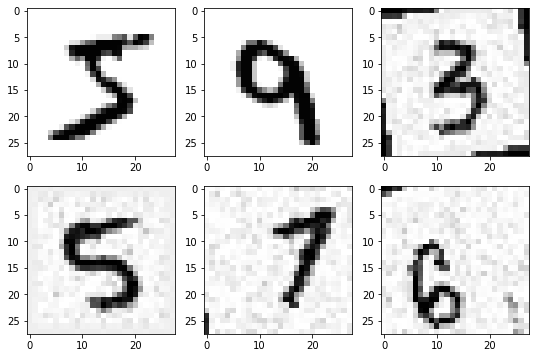

In [28]:
fig, axs = plt.subplots(2, 3, figsize=(9, 6))
axs[0, 0].imshow(X_train[0], "gray")
axs[0, 1].imshow(X_train[20001], "gray")
axs[0, 2].imshow(X_train[90002], "gray")
axs[1, 0].imshow(X_train[114000], "gray")
axs[1, 1].imshow(X_train[160000], "gray")
axs[1, 2].imshow(X_train[200000], "gray")
plt.show()

In [17]:
X_train.shape

(240000, 28, 28)

In [18]:
y_train.shape

(240000,)

In [19]:
X_test.shape

(50000, 28, 28)

In [20]:
y_test.shape

(50000,)

In [21]:
X_train = X_train.reshape(X_train.shape[0],28,28, 1)
X_test = X_test.reshape(X_test.shape[0],28,28, 1)

In [22]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Модель попроще:

In [23]:
model = Sequential()

#add model layers
model.add(Conv2D(128, kernel_size=3, activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

Модель посложнее

In [599]:
model = Sequential()



model.add(Conv2D(32, kernel_size=3,
                 activation='relu',
                 input_shape=(28,28,1)))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [600]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [601]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=6,  shuffle=True)

Train on 240000 samples, validate on 50000 samples
Epoch 1/6
240000/240000 [==============================] - 861s 4ms/step - loss: 0.8001 - accuracy: 0.7686 - val_loss: 0.2545 - val_accuracy: 0.9318
Epoch 2/6
240000/240000 [==============================] - 606s 3ms/step - loss: 0.3977 - accuracy: 0.8780 - val_loss: 0.1825 - val_accuracy: 0.9518
Epoch 3/6
240000/240000 [==============================] - 646s 3ms/step - loss: 0.3333 - accuracy: 0.8981 - val_loss: 0.1580 - val_accuracy: 0.9583
Epoch 4/6
240000/240000 [==============================] - 588s 2ms/step - loss: 0.3047 - accuracy: 0.9083 - val_loss: 0.1840 - val_accuracy: 0.9542
Epoch 5/6
240000/240000 [==============================] - 543s 2ms/step - loss: 0.2860 - accuracy: 0.9136 - val_loss: 0.1440 - val_accuracy: 0.9605
Epoch 6/6
240000/240000 [==============================] - 511s 2ms/step - loss: 0.2706 - accuracy: 0.9185 - val_loss: 0.1334 - val_accuracy: 0.9606


In [602]:
model.save_weights('mnist_detection_model_5')

In [603]:
model_json = model.to_json()
open("model_5.json", "w").write(model_json)

In [247]:
def process_image_before_recognizing(filename):
    delta = 0
    separator = 120
    im = Image.open(filename)
    initial_image = Image.open(filename)
    enhancer = ImageEnhance.Contrast(im)

    factor = 10
    im = np.array(enhancer.enhance(factor))
    
    morph = im.copy()

    gray_image = np.min(im, axis=2)
    #plt.imshow(foo, "gray")

    result = ndimage.gaussian_filter(gray_image, 0)
    #result = ndimage.minimum_filter(result, size=3)

    #foo = Image.open("seven.png")
    #foo = foo.resize((28 +2 * delta,28 + 2 * delta), Image.NEAREST)
    #im = np.array(foo)
    #gray_image = np.min(im, axis=2)
    #gray_image = gray_image[: , : ]
    gray_image_for_prediction=result
    im_from_array = Image.fromarray(gray_image_for_prediction)
    im_from_array = im_from_array.resize((28 +2 * delta,28 + 2 * delta),Image.ANTIALIAS)
    #gray_image = (gray_image) * (20 / 255)
    gray_image_for_prediction = np.array(im_from_array).reshape(28, 28)
    gray_image_for_prediction[gray_image_for_prediction > separator] = 255
    return gray_image_for_prediction

In [208]:
def recognize_and_print_digit(filename):
    delta = 0
    separator = 120
    im = Image.open(filename)
    initial_image = Image.open(filename)
    enhancer = ImageEnhance.Contrast(im)

    factor = 10
    im = np.array(enhancer.enhance(factor))
    
    morph = im.copy()

    gray_image = np.min(im, axis=2)

    result = ndimage.gaussian_filter(gray_image, 0)

    gray_image_for_prediction=result
    im_from_array = Image.fromarray(gray_image_for_prediction)
    im_from_array = im_from_array.resize((28 +2 * delta,28 + 2 * delta),Image.ANTIALIAS)
    gray_image_for_prediction = np.array(im_from_array).reshape(28, 28)
    gray_image_for_prediction[gray_image_for_prediction > separator] = 255
    print(np.argmax(model.predict(gray_image_for_prediction.reshape(1, 28, 28, 1))),
         np.max(model.predict(gray_image_for_prediction.reshape(1, 28, 28, 1))))
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(gray_image_for_prediction, "gray")
    ax[1].imshow(initial_image)
    plt.show()

2 0.9999864


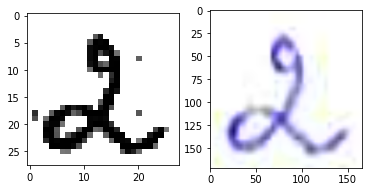

6 0.6505352


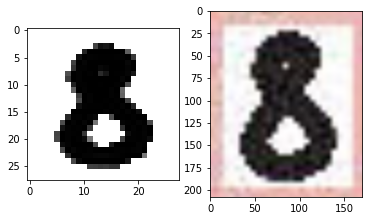

0 0.9999627


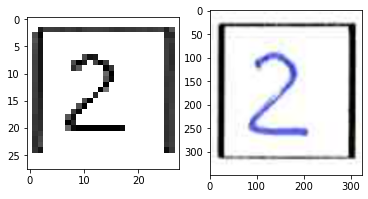

2 0.99987733


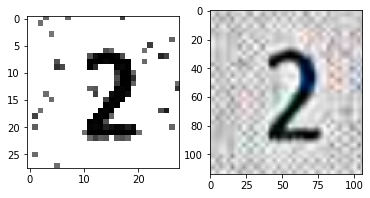

7 0.9851208


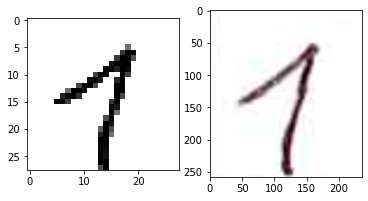

2 0.92122567


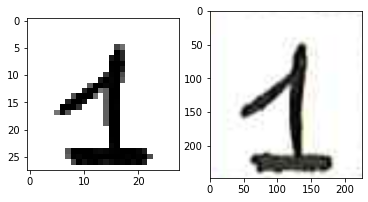

9 0.83847


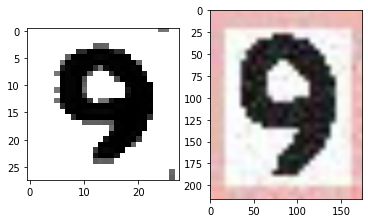

8 0.99999475


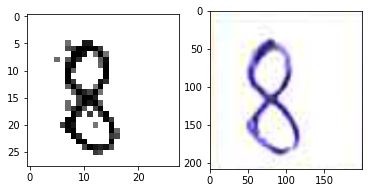

2 0.9999999


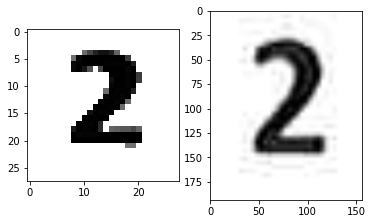

6 0.9963642


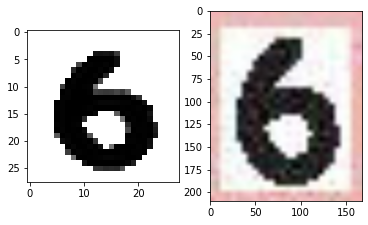

8 0.7552995


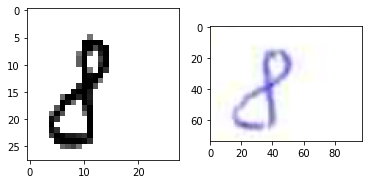

5 0.9968972


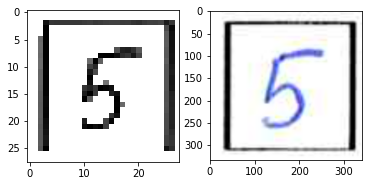

0 0.99999726


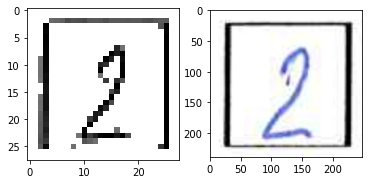

5 0.6017184


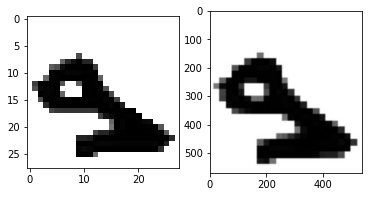

2 0.7064448


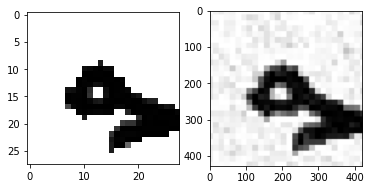

6 0.73445165


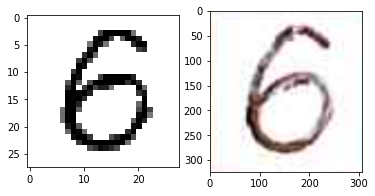

0 0.28592193


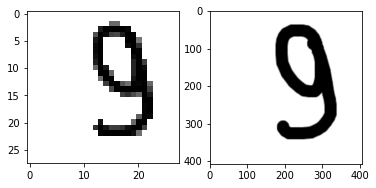

6 0.9999988


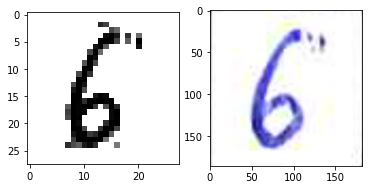

0 0.6843902


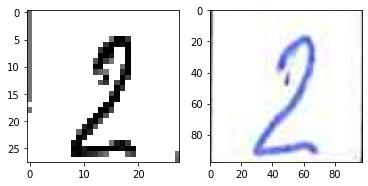

2 0.99988866


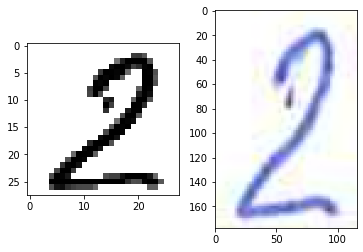

0 1.0


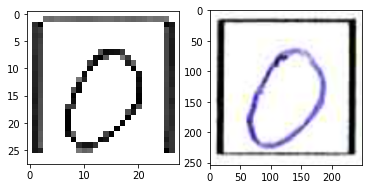

9 0.99917465


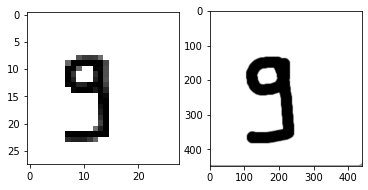

0 0.99999


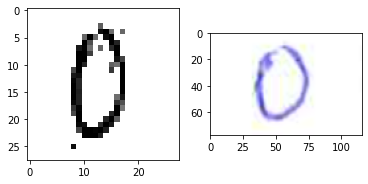

6 1.0


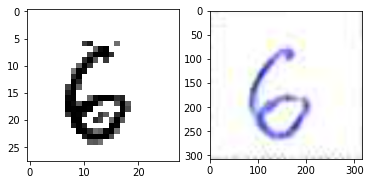

0 0.7369846


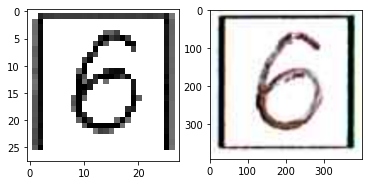

0 1.0


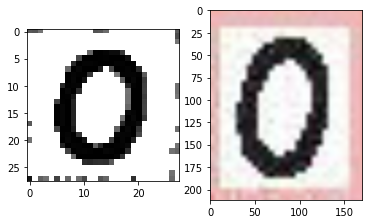

4 1.0


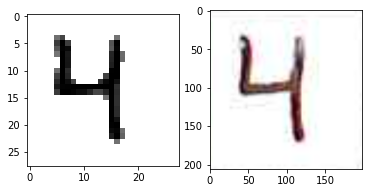

3 0.9997799


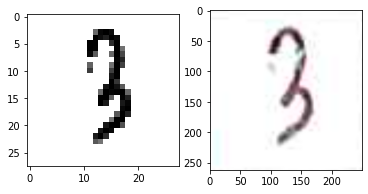

0 0.9998684


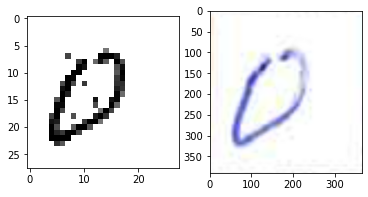

1 1.0


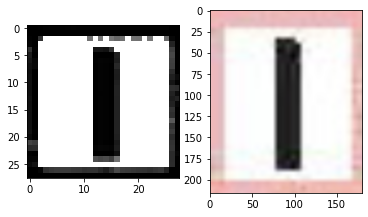

6 1.0


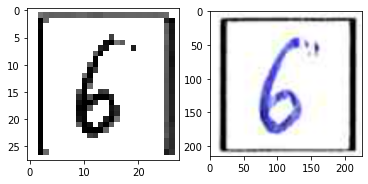

4 0.99696296


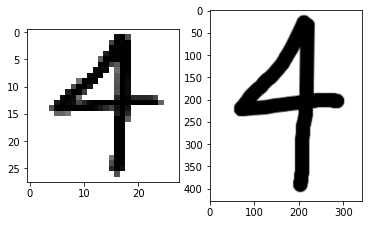

2 0.94853735


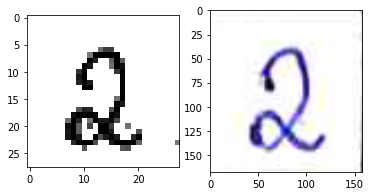

4 0.9941223


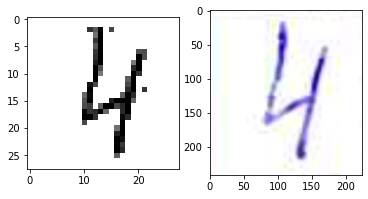

3 0.9999939


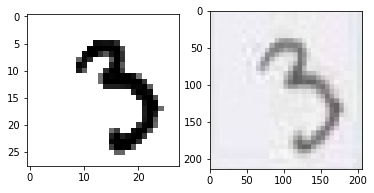

7 0.9895258


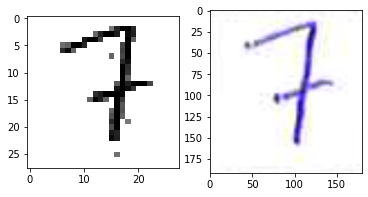

6 0.99998534


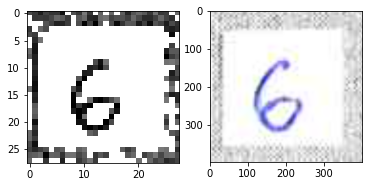

6 1.0


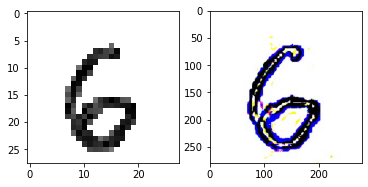

5 1.0


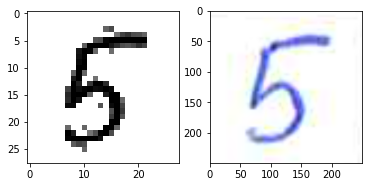

2 1.0


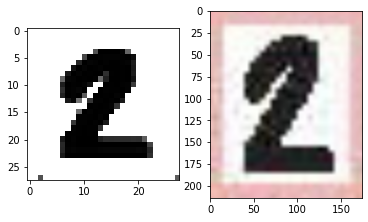

6 0.99999833


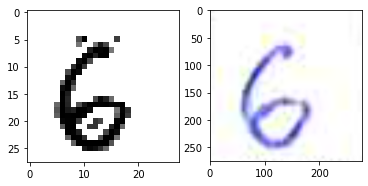

2 0.9998424


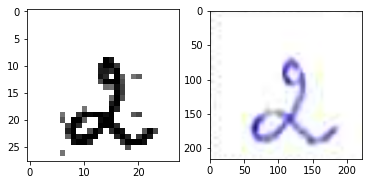

6 1.0


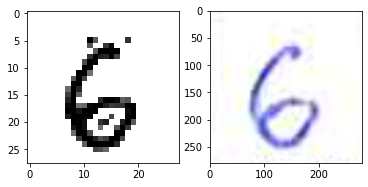

2 0.99848574


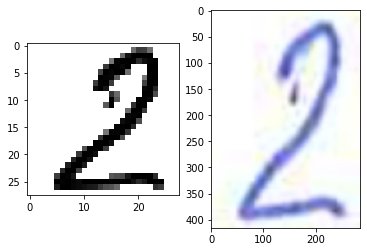

5 0.99982977


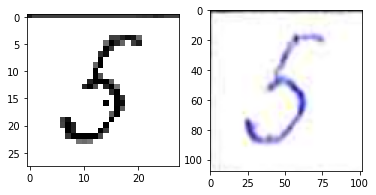

7 0.9226241


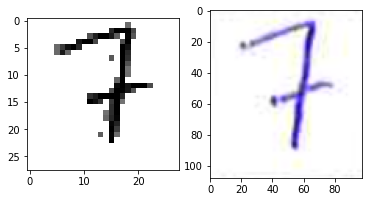

4 0.9995326


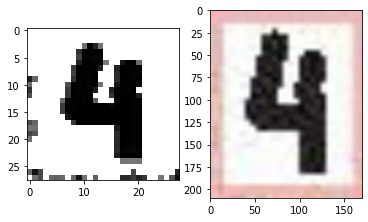

7 0.9908183


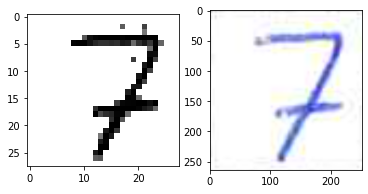

6 0.9999552


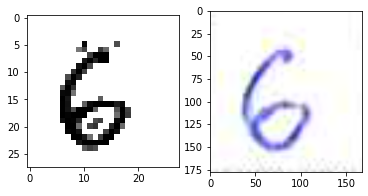

0 1.0


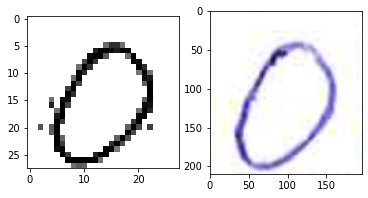

3 1.0


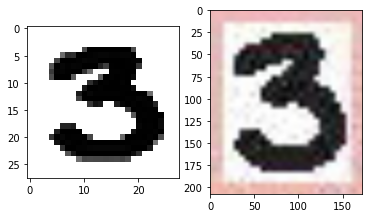

0 1.0


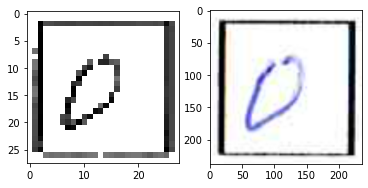

6 0.99896884


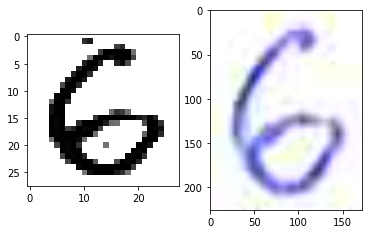

0 0.99977714


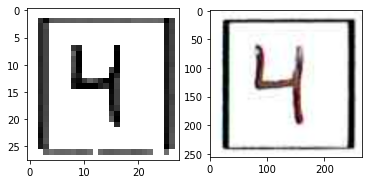

5 1.0


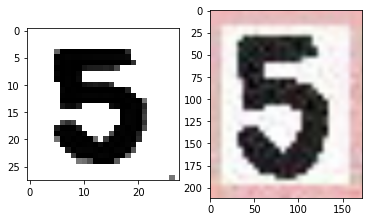

0 1.0


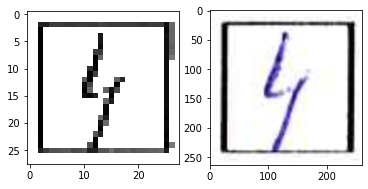

0 0.9990934


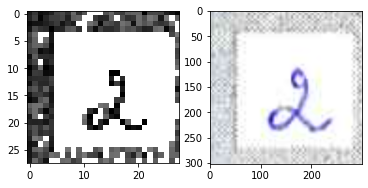

8 0.4163152


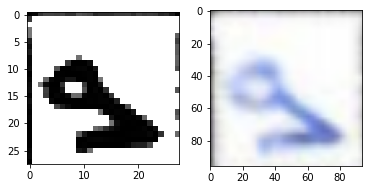

8 0.5630228


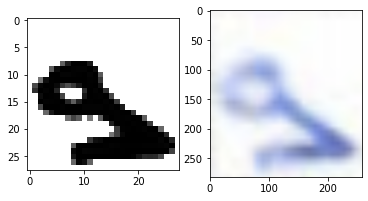

7 0.93857247


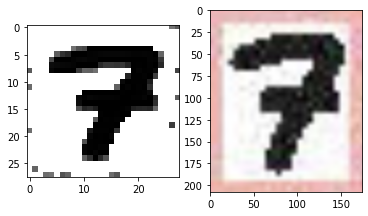

2 0.99994516


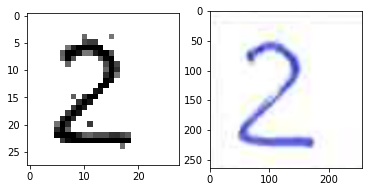

In [417]:
import os
for filename in os.listdir():
    if filename.endswith(".png") or filename.endswith(".jpg"):
        recognize_and_print_digit(filename)